In [1]:
# necessary libraries for prediciton
import utils
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

# Useful Functions

In [2]:
def pretty_matrix(matrix, row_label, col_label):
    """Pretty print of the given matrix """

    # Restraining labels that are too big
    row_label = [el[:10] + '..' if len(el) > 10 else el
                for el in row_label]
    col_label = [el[:10] + '..' if len(el) > 10 else el
                for el in col_label]

    # Stringfying everything & Joining top label
    s_matrix = [list([" "] + (col_label))] + \
               [[row_label[row_idx]] + \
                [str(e) for e in row] for row_idx, row in enumerate(matrix)]

    # Length of each matrix column
    len_s = [max(map(len, col)) for col in zip(*s_matrix)]

    # Cell formatation
    formatation = '\t'.join('{{:{}}}'.format(x) for x in len_s)

    # Apply cell formation to each matrix element
    pretty_mat = [formatation.format(*row) for row in s_matrix]

    # Print Pretty Matrix
    print('\n'.join(pretty_mat))


def display_confusion_matrix(values):
    '''Display the given array as a confusion matrix'''
    pretty_matrix([values[0:2], values[2:4]],
                  ['Actual NO', 'Actual YES'],
                  ['Predic NO', 'Predic YES'])

# Prediction Algorithms

* Decision Tree

In [3]:
def create_DT():
    '''Create a new Decision Tree'''
    # Useful DecisionTree tutorial:
    # https://www.datacamp.com/community/tutorials/decision-tree-classification-python
    return DecisionTreeClassifier()

In [4]:
def create_RF():
    '''Create a new Ranfom Forest model'''
    return RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

* Deep Learning

# Prediction

In [5]:
dataset =  utils.read_csv_to_df('dataset/preprocessed_data.csv')
display(dataset.head())

,date,amount,duration,payments,account_creation_date,frequency_MI,frequency_WI,balance_mean,balance_max,balance_min,...,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,owner_count,disponent_count,owner_gender,owner_birthdate,loan_to_account_age,salary_over_payments,status
0,0.000000,96396,12,8033,0.054011,0,1,12250.000000,20100.0,1100.0,...,100,2985,2804,1,1,1,0.272076,105,1617,-1
1,0.262785,52128,24,2172,0.193010,1,0,33459.680282,59944.2,144.2,...,100,2985,2804,1,1,1,0.533465,264,7478,1
2,0.004721,165960,36,4610,0.024623,1,0,52083.859459,120512.8,700.0,...,117,2854,2618,1,1,0,0.730073,148,3759,1
3,0.018096,127080,60,2118,0.020651,1,0,30060.954167,49590.4,800.0,...,132,2080,2122,1,1,0,0.029255,170,6272,1
4,0.306845,74736,36,2076,0.130262,1,0,37912.998507,62084.0,700.0,...,132,2080,2122,1,1,0,0.670547,399,6314,1


In [6]:
# Useful MACROS
STATUS_COL = dataset.columns.get_loc("status")
K_FOLD_NUM_SPLITS = 5
SEED = 42

In [7]:
# Setting X and Y
X = dataset.iloc[:, 0:STATUS_COL]
y = dataset.iloc[:, [STATUS_COL]]

Epoch 1/200
1/1 [==============================] - 0s 280ms/step - loss: 1.0626 - binary_accuracy: 0.4593 - val_loss: 20.2775 - val_binary_accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 22ms/step - loss: 0.8812 - binary_accuracy: 0.4959 - val_loss: 14.1552 - val_binary_accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 21ms/step - loss: 0.8828 - binary_accuracy: 0.4756 - val_loss: 11.3491 - val_binary_accuracy: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 0s 26ms/step - loss: 1.0388 - binary_accuracy: 0.4919 - val_loss: 9.6234 - val_binary_accuracy: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 22ms/step - loss: 0.9089 - binary_accuracy: 0.4675 - val_loss: 8.4236 - val_binary_accuracy: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 23ms/step - loss: 0.8918 - binary_accuracy: 0.4756 - val_loss: 7.4948 - val_binary_accuracy: 0.0000e+00
Epoch 7/200
1/1 [==============================]

1/1 [==============================] - 0s 22ms/step - loss: 0.2971 - binary_accuracy: 0.6301 - val_loss: 0.5032 - val_binary_accuracy: 0.5976
Epoch 54/200
1/1 [==============================] - 0s 22ms/step - loss: 0.3253 - binary_accuracy: 0.5813 - val_loss: 0.4928 - val_binary_accuracy: 0.6098
Epoch 55/200
1/1 [==============================] - 0s 21ms/step - loss: 0.2941 - binary_accuracy: 0.6382 - val_loss: 0.4824 - val_binary_accuracy: 0.6220
Epoch 56/200
1/1 [==============================] - 0s 21ms/step - loss: 0.3096 - binary_accuracy: 0.6341 - val_loss: 0.4733 - val_binary_accuracy: 0.6707
Epoch 57/200
1/1 [==============================] - 0s 21ms/step - loss: 0.2000 - binary_accuracy: 0.6382 - val_loss: 0.4644 - val_binary_accuracy: 0.6707
Epoch 58/200
1/1 [==============================] - 0s 20ms/step - loss: 0.2499 - binary_accuracy: 0.6504 - val_loss: 0.4560 - val_binary_accuracy: 0.6829
Epoch 59/200
1/1 [==============================] - 0s 32ms/step - loss: 0.2440 - b

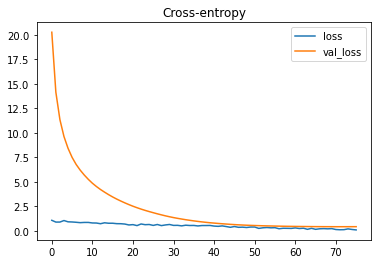

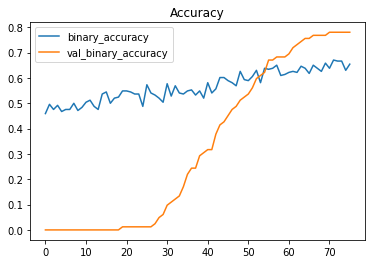

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

auc_scores = []
confusion_matrixes = []

X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

input_shape = [X_train.shape[1]]

neurons = 25

model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape),
    layers.Dense(neurons, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(neurons, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer ='adam',
    loss = 'binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
print(history_df.columns)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

y_pred = model.predict(X_valid)
    
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = -1
y_pred = y_pred.astype(int)
fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred)
auc_scores.append(metrics.auc(fpr, tpr))
confusion_matrixes.append(metrics.confusion_matrix(y_valid, y_pred).ravel())

classifier = model


In [ ]:
# Cross validation settings
auc_scores = []
confusion_matrixes = []
cv = KFold(n_splits=K_FOLD_NUM_SPLITS, random_state=SEED, shuffle=False)

# CHANGE THIS LINE TO CHANGE THE USED CLASSIFICATION METHOD
classifier = model
# classifier = create_RF()

# Applying Cross validation
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training with this fold
    classifier.fit(X_train, y_train)
    
    # Testing & Measuring accuracy
    y_pred = classifier.predict(X_test)
    
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = -1
    y_pred = y_pred.astype(int)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc_scores.append(metrics.auc(fpr, tpr))
    confusion_matrixes.append(metrics.confusion_matrix(y_test, y_pred).ravel())

In [9]:
# Printing the obtained results
print('Classification Method used:', classifier, '\n')
print('AUC scores:', auc_scores)
print('> Average: ', sum(auc_scores)/len(auc_scores))
for cf in confusion_matrixes:
    display_confusion_matrix(cf)

Classification Method used: <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000023A081941F0> 

AUC scores: [0.7071428571428571]
> Average:  0.7071428571428571
          	Predic NO	Predic YES
Actual NO 	6        	6         
Actual YES	6        	64        


### After having our model trained we shall use the model on the data to be sumitted in the kaggle

In [10]:
test_dataset =  utils.read_csv_to_df('dataset/test_dataset.csv')
ids = utils.read_csv_to_df('dataset/ids.csv')
display(test_dataset.head())

,date,amount,duration,payments,account_creation_date,frequency_MI,frequency_WI,balance_mean,balance_max,balance_min,...,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,owner_count,disponent_count,owner_gender,owner_birthdate,loan_to_account_age,salary_over_payments,status
0,0.000000,93960,60,1566,0.176892,1,0,54520.202247,88246.7,800.0,...,132,2080,2122,1,1,0,0.591135,452,6824,NaN
1,0.664773,50976,36,1416,0.610429,1,0,28050.299187,48735.9,400.0,...,132,2080,2122,1,1,0,0.980347,496,6974,NaN
2,0.761364,184620,60,3077,0.567485,1,0,34785.534513,65517.7,1100.0,...,132,2080,2122,1,1,1,0.620033,606,5313,NaN
3,0.001420,260640,36,7240,0.139059,1,0,31518.182051,88731.8,-718.6,...,100,1089,1117,1,1,1,0.292414,490,1380,NaN
4,0.529830,136368,24,5682,0.754601,1,0,60593.840678,119446.2,600.0,...,100,1089,1117,1,1,0,0.749709,260,2938,NaN


In [11]:
# We now remove the Y column with NaNs
test_dataset = test_dataset.iloc[:, 0:STATUS_COL]
display(test_dataset.head())

,date,amount,duration,payments,account_creation_date,frequency_MI,frequency_WI,balance_mean,balance_max,balance_min,...,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,owner_count,disponent_count,owner_gender,owner_birthdate,loan_to_account_age,salary_over_payments
0,0.000000,93960,60,1566,0.176892,1,0,54520.202247,88246.7,800.0,...,2.89,132,2080,2122,1,1,0,0.591135,452,6824
1,0.664773,50976,36,1416,0.610429,1,0,28050.299187,48735.9,400.0,...,2.89,132,2080,2122,1,1,0,0.980347,496,6974
2,0.761364,184620,60,3077,0.567485,1,0,34785.534513,65517.7,1100.0,...,2.89,132,2080,2122,1,1,1,0.620033,606,5313
3,0.001420,260640,36,7240,0.139059,1,0,31518.182051,88731.8,-718.6,...,1.25,100,1089,1117,1,1,1,0.292414,490,1380
4,0.529830,136368,24,5682,0.754601,1,0,60593.840678,119446.2,600.0,...,1.25,100,1089,1117,1,1,0,0.749709,260,2938


In [12]:
# Using the model to get the 'status' predictions
display(test_dataset)
predictions_df = test_dataset.copy()
predictions_df['Predicted'] = classifier.predict(test_dataset)
predictions_df = ids.merge(predictions_df, on=['date', 'amount'])
predictions_df = predictions_df[['loan_id', 'Predicted']]\
                    .rename(columns={
                        'loan_id': 'Id'
                    })\
                    .drop_duplicates()
predictions_df.loc[predictions_df['Predicted'] >= 0.5, 'Predicted'] = 1
predictions_df.loc[predictions_df['Predicted'] < 0.5, 'Predicted'] = -1
predictions_df['Predicted'] = predictions_df['Predicted'].astype(int)
display(predictions_df)

,date,amount,duration,payments,account_creation_date,frequency_MI,frequency_WI,balance_mean,balance_max,balance_min,...,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96,owner_count,disponent_count,owner_gender,owner_birthdate,loan_to_account_age,salary_over_payments
0,0.000000,93960,60,1566,0.176892,1,0,54520.202247,88246.7,800.0,...,2.89,132,2080,2122,1,1,0,0.591135,452,6824
1,0.664773,50976,36,1416,0.610429,1,0,28050.299187,48735.9,400.0,...,2.89,132,2080,2122,1,1,0,0.980347,496,6974
2,0.761364,184620,60,3077,0.567485,1,0,34785.534513,65517.7,1100.0,...,2.89,132,2080,2122,1,1,1,0.620033,606,5313
3,0.001420,260640,36,7240,0.139059,1,0,31518.182051,88731.8,-718.6,...,1.25,100,1089,1117,1,1,1,0.292414,490,1380
4,0.529830,136368,24,5682,0.754601,1,0,60593.840678,119446.2,600.0,...,1.25,100,1089,1117,1,1,0,0.749709,260,2938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,0.897727,39168,24,1632,0.930470,1,0,55438.851852,81495.6,300.0,...,2.87,130,4289,4846,1,1,1,0.965224,347,8288
350,0.913352,38496,12,3208,0.897751,1,0,42732.336111,92238.0,800.0,...,2.87,130,4289,4846,1,1,1,0.628360,390,6712
351,0.970170,99744,24,4156,0.802658,0,1,40126.968627,79967.9,700.0,...,2.87,130,4289,4846,1,1,1,0.797771,523,5764
352,0.889205,253560,60,4226,0.619632,1,0,39822.711111,76509.7,900.0,...,9.40,90,4947,4743,1,1,1,0.346293,645,6220


,Id,Predicted
0,5895,1
1,5172,1
2,6207,1
3,7122,-1
4,7067,1
...,...,...
361,7294,1
362,6321,1
363,6469,1
364,5614,1


In [15]:
# Outputting predictions to .csv
# CHANGE FILE NAME TO PRESERVE DIFFERENT INSTANCES
utils.write_df_to_csv(predictions_df, 'predictions', 'prediction3.csv')